# Create data to perform Multiple Sequnce Alignment for fep system in Escherichia coli cohort

## Read `fep system` gene sequences

In [1]:
import os
from pathlib import Path

import pandas as pd

from Bio.SeqRecord import SeqRecord

from io import StringIO

geneNames = ['fepA', 'fepB', 'fepC', 'fepD', 'fepE', 'fepG'] # list obtained from this paper

fastaData = {}
gff3Path = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'gff3_original')

dfList = []

for gff3FileName in os.listdir(gff3Path):

    gff3File = Path(gff3Path, gff3FileName)

    tubeId = gff3FileName.split('.')[0]

    gff3Lines = []
    fasta_start_index = None
    with open(gff3File, 'r') as in_handle:
        gff3Lines = in_handle.readlines()

    for i, line in enumerate(gff3Lines):
        if line.strip() == "##FASTA":
            fasta_start_index = i + 1
            break

    gff3Info = StringIO("".join(gff3Lines[: fasta_start_index]))

    df = pd.read_csv(gff3Info, sep='\t', comment='#', header=None, names=['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
    df['gene'] = df.attributes.str.split(';').apply(lambda x: [item.split('=')[1] for item in x if item.split('=')[0] == 'gene']).apply(lambda x: x[0] if x else None)
    df = df[df.gene.isin(geneNames)]
    df['tube_id'] = tubeId

    dfList.append(df)

allGenesDf = pd.concat(dfList, ignore_index=True)
allGenesDf

,seq_id,source,type,start,end,score,strand,phase,attributes,gene,tube_id
0,1,Prodigal,CDS,3487,5859,.,-,0,ID=EFLFLN_00010;Name=Outer membrane receptor f...,fepA,AH19A073
1,14,Prodigal,CDS,20974,23214,.,-,0,ID=EFLFLN_17535;Name=ferrienterobactin outer m...,fepA,AH19A073
2,14,Prodigal,CDS,28974,30107,.,+,0,ID=EFLFLN_17555;Name=LPS O-antigen length regu...,fepE,AH19A073
3,14,Prodigal,CDS,30104,30919,.,-,0,ID=EFLFLN_17560;Name=ferrienterobactin ABC tra...,fepC,AH19A073
4,14,Prodigal,CDS,30916,31908,.,-,0,ID=EFLFLN_17565;Name=iron-enterobactin ABC tra...,fepG,AH19A073
...,...,...,...,...,...,...,...,...,...,...,...
11676,4,Prodigal,CDS,186059,187081,.,-,0,ID=GOAIKP_09045;Name=ABC-type Fe3+-hydroxamate...,fepB,AH19K033
11677,5,Prodigal,CDS,247544,248353,.,+,0,ID=GOAIKP_11135;Name=ABC-type cobalamin/Fe3+-s...,fepC,AH19K033
11678,5,Prodigal,CDS,248350,249333,.,+,0,ID=GOAIKP_11140;Name=ABC-type Fe3+-siderophore...,fepD,AH19K033
11679,5,Prodigal,CDS,249330,250379,.,+,0,ID=GOAIKP_11145;Name=ABC-type Fe3+-siderophore...,fepD,AH19K033


## Explore

In [2]:
allGenesDf.seq_id.value_counts()

seq_id
1      1912
2      1441
3      1163
4      1107
5       749
       ... 
54        1
100       1
167       1
96        1
52        1
Name: count, Length: 70, dtype: int64

In [3]:
import pandas as pd
import numpy as np


pivotedGenesDf = pd.pivot_table(data=allGenesDf[['gene', 'tube_id']], columns='gene', index='tube_id', aggfunc=np.count_nonzero).fillna(0).astype(bool)
pivotedGenesDf

gene,fepA,fepB,fepC,fepD,fepE,fepG
tube_id,,,,,,
AH18J011,True,True,True,True,True,True
AH18J016,True,True,True,True,True,True
AH18J019,True,True,True,True,True,True
AH18J032,True,True,True,True,True,True
AH18J033,True,True,True,True,True,True
...,...,...,...,...,...,...
ALF23C186,True,True,True,True,False,True
ALF23C187,True,True,True,True,True,True
ALF23C213,True,True,True,True,False,True


In [4]:
pivotedGenesDf.reset_index(drop=True).sum()

gene
fepA    860
fepB    861
fepC    861
fepD    861
fepE    808
fepG    861
dtype: int64

In [5]:
groupedGenesDf = allGenesDf[allGenesDf.gene.isin(['fepA', 'fepB', 'fepC', 'fepD', 'fepG'])].groupby(by=['tube_id', 'gene'])['seq_id'].agg(list_of_contigs=lambda x: set(x)).reset_index()
groupedGenesDf.list_of_contigs.apply(lambda x: len(x)).value_counts()
# groupedGenesDf

list_of_contigs
3    2434
1    1131
2     643
4      96
Name: count, dtype: int64

In [6]:
groupedGenesDf['contig'] = groupedGenesDf.list_of_contigs.apply(lambda x: list(x)[0])
groupedGenesDf

,tube_id,gene,list_of_contigs,contig
0,AH18J011,fepA,"{1, 28, 5}",1
1,AH18J011,fepB,"{1, 2, 5}",1
2,AH18J011,fepC,"{1, 2, 5}",1
3,AH18J011,fepD,"{1, 2, 5}",1
4,AH18J011,fepG,{1},1
...,...,...,...,...
4299,ALF23C222,fepA,"{2, 3, 21}",2
4300,ALF23C222,fepB,"{2, 3, 4}",2
4301,ALF23C222,fepC,"{2, 3, 4}",2
4302,ALF23C222,fepD,"{2, 3, 4}",2


In [7]:
allGenesDf

,seq_id,source,type,start,end,score,strand,phase,attributes,gene,tube_id
0,1,Prodigal,CDS,3487,5859,.,-,0,ID=EFLFLN_00010;Name=Outer membrane receptor f...,fepA,AH19A073
1,14,Prodigal,CDS,20974,23214,.,-,0,ID=EFLFLN_17535;Name=ferrienterobactin outer m...,fepA,AH19A073
2,14,Prodigal,CDS,28974,30107,.,+,0,ID=EFLFLN_17555;Name=LPS O-antigen length regu...,fepE,AH19A073
3,14,Prodigal,CDS,30104,30919,.,-,0,ID=EFLFLN_17560;Name=ferrienterobactin ABC tra...,fepC,AH19A073
4,14,Prodigal,CDS,30916,31908,.,-,0,ID=EFLFLN_17565;Name=iron-enterobactin ABC tra...,fepG,AH19A073
...,...,...,...,...,...,...,...,...,...,...,...
11676,4,Prodigal,CDS,186059,187081,.,-,0,ID=GOAIKP_09045;Name=ABC-type Fe3+-hydroxamate...,fepB,AH19K033
11677,5,Prodigal,CDS,247544,248353,.,+,0,ID=GOAIKP_11135;Name=ABC-type cobalamin/Fe3+-s...,fepC,AH19K033
11678,5,Prodigal,CDS,248350,249333,.,+,0,ID=GOAIKP_11140;Name=ABC-type Fe3+-siderophore...,fepD,AH19K033
11679,5,Prodigal,CDS,249330,250379,.,+,0,ID=GOAIKP_11145;Name=ABC-type Fe3+-siderophore...,fepD,AH19K033


In [13]:
geneLocationsDf = allGenesDf.groupby(by=['tube_id', 'seq_id', 'gene', 'strand']).agg({'start': 'first', 'end': 'first'}).reset_index()
geneLocationsDf['seq_length'] = (geneLocationsDf.end - geneLocationsDf.start)
# groupLocationsDf = groupLocationsDf[groupLocationsDf.seq_length > 9000]
geneLocationsDf

,tube_id,seq_id,gene,strand,start,end,seq_length
0,AH18J011,1,fepA,-,11877,14117,2240
1,AH18J011,1,fepB,-,25177,26133,956
2,AH18J011,1,fepC,-,21007,21822,815
3,AH18J011,1,fepD,-,22808,23812,1004
4,AH18J011,1,fepE,+,19877,21010,1133
...,...,...,...,...,...,...,...
10907,ALF23C222,3,fepG,-,379939,380931,992
10908,ALF23C222,4,fepB,-,127710,128657,947
10909,ALF23C222,4,fepC,-,130694,131503,809
10910,ALF23C222,4,fepD,-,128668,129717,1049


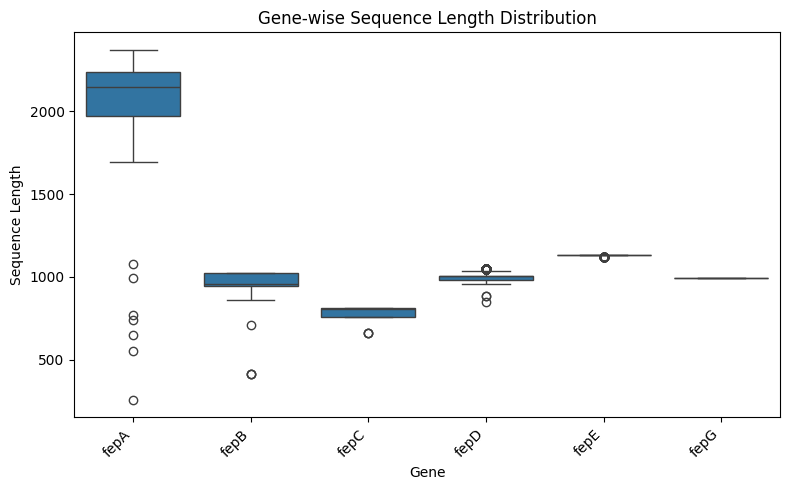

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have groupLocationsDf loaded as a DataFrame

# Group by gene and collect all sequence lengths
plt.figure(figsize=(8, 5))
sns.boxplot(data=geneLocationsDf, y="seq_length", x="gene")

# Optional aesthetics
plt.xticks(rotation=45, ha='right')
plt.title("Gene-wise Sequence Length Distribution")
plt.xlabel("Gene")
plt.ylabel("Sequence Length")
plt.tight_layout()
plt.show()

## Function to obtain sequence

In [10]:
def getSequenceData(gff3Lines, fasta_start_index, seqId, strand, startLocation, endLocation):

    from io import StringIO
    from Bio import SeqIO

    fasta_data = StringIO("".join(gff3Lines[fasta_start_index:]))
    seq_dict = SeqIO.to_dict(SeqIO.parse(fasta_data, "fasta"))

    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    seq = ''
    if strand == '+':
        seq = seq_dict[seqId][startLocation - 1:endLocation].seq
    elif strand == '-':
        seq = ''.join([complement[base.upper()] for base in seq_dict[seqId][startLocation - 1:endLocation]][::-1])

    return seq

## Create FASTA data from location information

In [15]:
import os
from pathlib import Path

import pandas as pd

from Bio.SeqRecord import SeqRecord

from io import StringIO


fastaData = {}
gff3Path = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'gff3_original')

dfList = []

for gff3FileName in os.listdir(gff3Path):

    gff3File = Path(gff3Path, gff3FileName)

    tubeId = gff3FileName.split('.')[0]

    gff3Lines = []
    fasta_start_index = None
    with open(gff3File, 'r') as in_handle:
        gff3Lines = in_handle.readlines()

    for i, line in enumerate(gff3Lines):
        if line.strip() == "##FASTA":
            fasta_start_index = i + 1
            break

    systemRecords = {}
    for i, row in geneLocationsDf[geneLocationsDf.tube_id == tubeId].iterrows():
        seq = getSequenceData(
            gff3Lines=gff3Lines,
            fasta_start_index=fasta_start_index,
            seqId=str(row.seq_id),
            strand=str(row.strand),
            startLocation=row.start,
            endLocation=row.end,
        )
        systemRecords[row.gene] = seq
    mergedSequence = (
        systemRecords['fepB'] if 'fepB' in systemRecords else ''
    ) + (
        systemRecords['fepC'] if 'fepC' in systemRecords else ''
    ) + (
        systemRecords['fepD'] if 'fepD' in systemRecords else ''
    ) + (
        systemRecords['fepG'] if 'fepG' in systemRecords else ''
    ) + (
        systemRecords['fepA'] if 'fepA' in systemRecords else ''
    ) + (
        systemRecords['fepE'] if 'fepE' in systemRecords else ''
    )
    updatedRecord = SeqRecord(mergedSequence, id=tubeId, name=tubeId, description=tubeId)
    fastaData[tubeId] = updatedRecord


/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


## Write fasta file

In [16]:
import os
from pathlib import Path

from Bio import SeqIO


SeqIO.write(fastaData.values(), Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'gene_sequences', 'fep_system', 'sequence.fna'), 'fasta')

861